In [4]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

In [5]:
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url, header=0)
    tickers = table[0]['Symbol'].tolist()
    # Some tickers have '.' which yfinance expects as '-'
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    return tickers


end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

In [7]:
tickers = get_sp500_tickers()
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK-B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DAY', 'D

In [9]:
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

YF.download() has changed argument auto_adjust default to True


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Date']"

In [10]:
print(data.columns.tolist())
print(data.head())

[('Date', ''), ('Close', 'A'), ('Close', 'AAPL'), ('Close', 'ABBV'), ('Close', 'ABNB'), ('Close', 'ABT'), ('Close', 'ACGL'), ('Close', 'ACN'), ('Close', 'ADBE'), ('Close', 'ADI'), ('Close', 'ADM'), ('Close', 'ADP'), ('Close', 'ADSK'), ('Close', 'AEE'), ('Close', 'AEP'), ('Close', 'AES'), ('Close', 'AFL'), ('Close', 'AIG'), ('Close', 'AIZ'), ('Close', 'AJG'), ('Close', 'AKAM'), ('Close', 'ALB'), ('Close', 'ALGN'), ('Close', 'ALL'), ('Close', 'ALLE'), ('Close', 'AMAT'), ('Close', 'AMCR'), ('Close', 'AMD'), ('Close', 'AME'), ('Close', 'AMGN'), ('Close', 'AMP'), ('Close', 'AMT'), ('Close', 'AMZN'), ('Close', 'ANET'), ('Close', 'ANSS'), ('Close', 'AON'), ('Close', 'AOS'), ('Close', 'APA'), ('Close', 'APD'), ('Close', 'APH'), ('Close', 'APO'), ('Close', 'APTV'), ('Close', 'ARE'), ('Close', 'ATO'), ('Close', 'AVB'), ('Close', 'AVGO'), ('Close', 'AVY'), ('Close', 'AWK'), ('Close', 'AXON'), ('Close', 'AXP'), ('Close', 'AZO'), ('Close', 'BA'), ('Close', 'BAC'), ('Close', 'BALL'), ('Close', 'BAX'

In [22]:
# Step 1: Flatten column MultiIndex
data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in data.columns.values]

# Step 2: Melt wide format into long
data_melted = data.melt(id_vars=['Date'], var_name='variable', value_name='value')

# Step 3: Split the variable column into Attribute and Ticker
data_melted[['Attribute', 'Ticker']] = data_melted['variable'].str.split('_', expand=True)

# Step 4: Pivot so attributes become columns again
long_df = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first').reset_index()

# Step 5: Optional - tidy column names
long_df.columns.name = None

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Date']"

In [23]:
long_df.columns

Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume',
       'rolling_avg', 'rolling_std', 'volume_anomaly'],
      dtype='object')

In [24]:
long_df['rolling_avg'] = long_df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
long_df['rolling_std'] = long_df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).std())
long_df['volume_anomaly'] = long_df['Volume'] > (long_df['rolling_avg'] + 2 * long_df['rolling_std'])

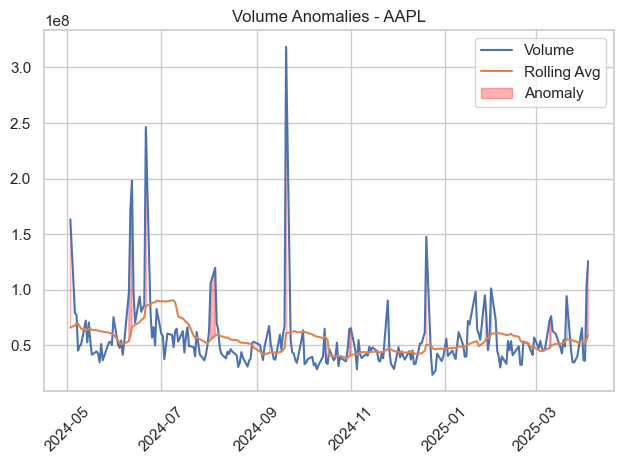

In [25]:
import matplotlib.pyplot as plt

sample = long_df[long_df['Ticker'] == 'AAPL'].dropna()

plt.plot(sample['Date'], sample['Volume'], label='Volume')
plt.plot(sample['Date'], sample['rolling_avg'], label='Rolling Avg')
plt.fill_between(sample['Date'], sample['Volume'], sample['rolling_avg'], 
                 where=sample['volume_anomaly'], color='red', alpha=0.3, label='Anomaly')
plt.legend()
plt.title('Volume Anomalies - AAPL')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

NameError: name 'stock_data' is not defined

<Figure size 1500x600 with 0 Axes>